### Imports

In [1]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import A2C
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

W0731 20:28:14.703795  7312 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Create Env

In [2]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

### Train Env

In [3]:
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=1000)

W0731 20:28:14.801740  7312 module_wrapper.py:139] From C:\Program Files\Python37\lib\site-packages\stable_baselines\common\tf_util.py:58: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0731 20:28:14.803742  7312 module_wrapper.py:139] From C:\Program Files\Python37\lib\site-packages\stable_baselines\common\tf_util.py:67: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0731 20:28:19.707756  7312 module_wrapper.py:139] From C:\Program Files\Python37\lib\site-packages\stable_baselines\common\policies.py:115: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0731 20:28:19.708775  7312 module_wrapper.py:139] From C:\Program Files\Python37\lib\site-packages\stable_baselines\common\input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 20:28:19.724752  7312 deprecation.py:323] From C:\Program Files\Python37\lib\site-packages\stable_ba

### Test Env

In [4]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 479.8018879999986, 'total_profit': 0.000450845754050001, 'position': 1}


### Plot Results

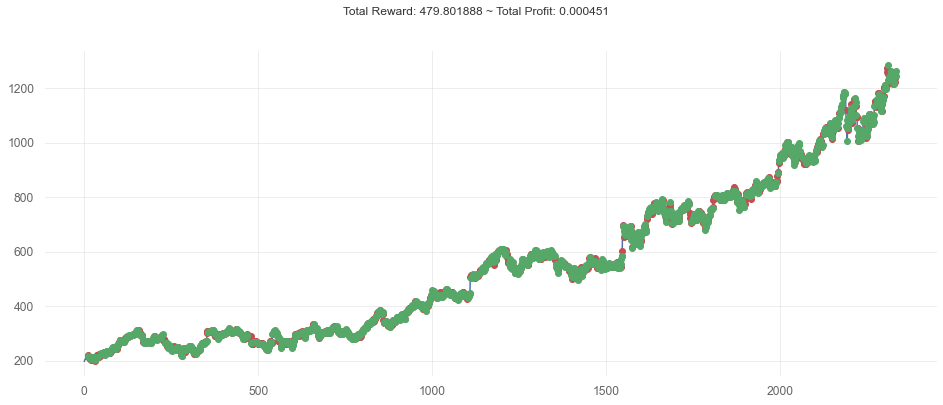

In [5]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -99.95%
CAGR%                      -56.62%
Sharpe                     -4.15
Sortino                    -4.46
Max Drawdown               -99.95%
Longest DD Days            3362
Volatility (ann.)          19.62%
Calmar                     -0.57
Skew                       -1.4
Kurtosis                   21.93

Expected Daily %           -0.33%
Expected Monthly %         -6.71%
Expected Yearly %          -53.72%
Kelly Criterion            -90.51%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.36%
Expected Shortfall (cVaR)  -2.36%

Payoff Ratio               0.7
Profit Factor              0.19
Common Sense Ratio         0.0
CPC Index                  0.03
Tail Ratio                 0.02
Outlier Win Ratio          22.04
Outlier Loss Ratio         2.27

MTD         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-15,2018-08-29,2018-08-29,3362,-99.954915,-99.948936


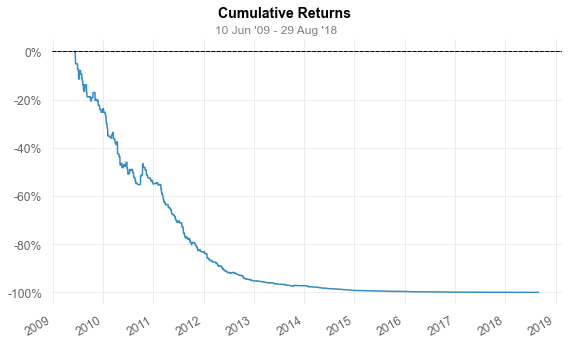

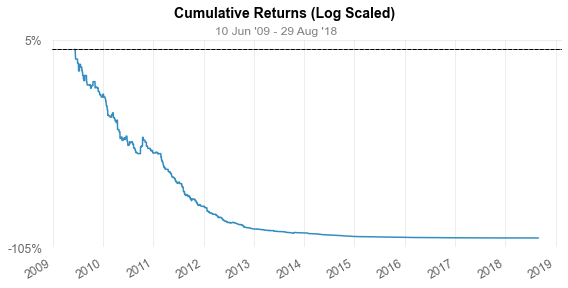

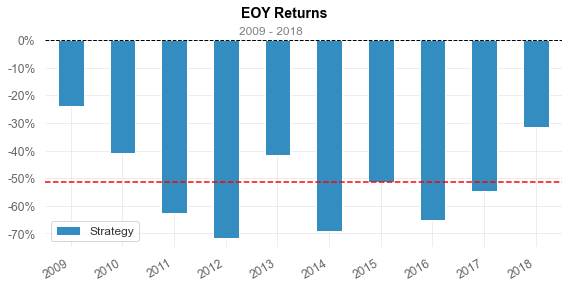

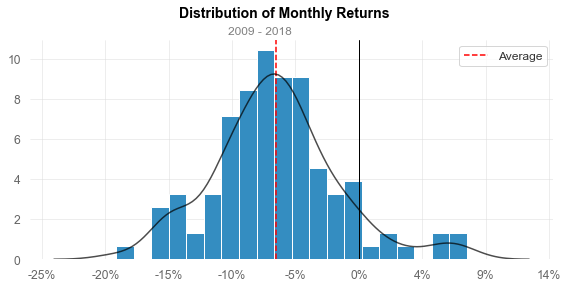

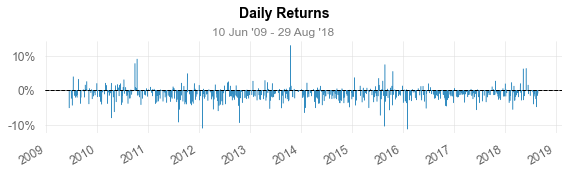

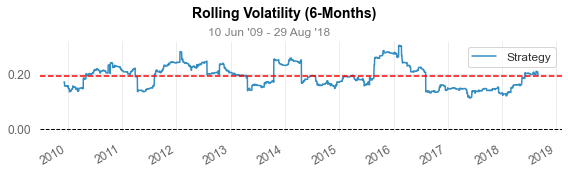

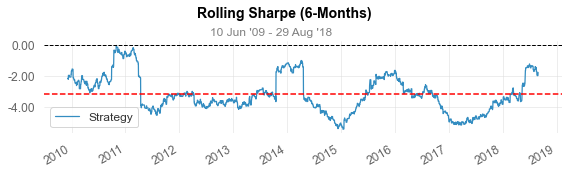

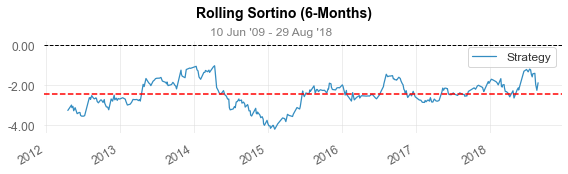

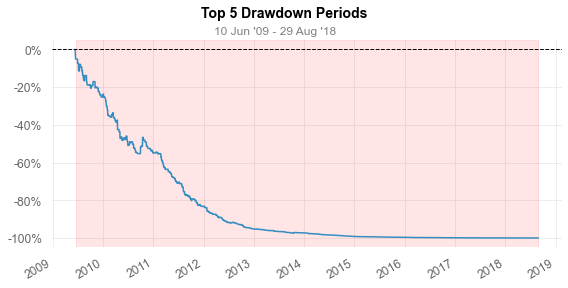

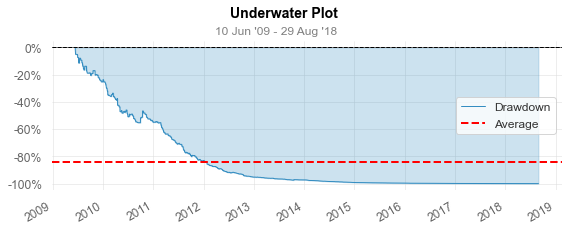

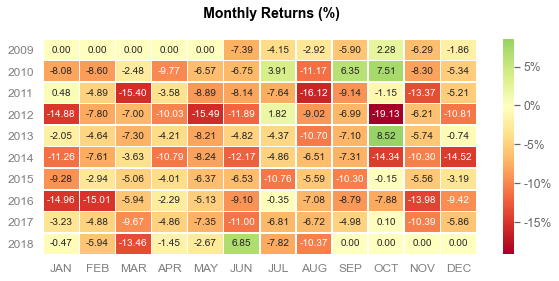

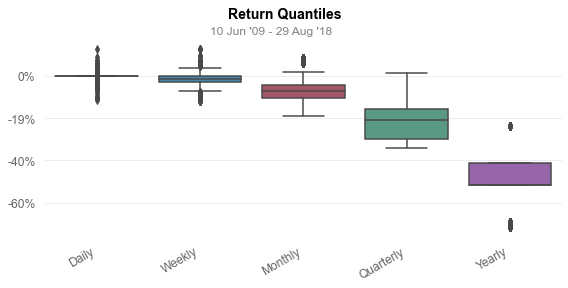

In [6]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')